In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime

In [61]:
df = pd.read_csv('../META_1min_firstratedata.csv')

In [70]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['avg_price'] = (df['high'] + df['low']) / 2
df.set_index('timestamp', inplace=True)

trading_hours_df = df.between_time('09:30', '16:00').copy()

In [76]:
def calculate_all_daily_curves(df):
    # Ensure the index is a DatetimeIndex before proceeding
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("DataFrame index must be a DatetimeIndex.")

    grouped_by_day = trading_hours_df.groupby(trading_hours_df.index.date)

    daily_curves = {}

    # Iterate over each day's data group
    for date, daily_group in grouped_by_day:
        # Calculate the cumulative sum of volume for that day
        cumulative_vol = daily_group['volume'].cumsum()
        
        # Calculate the total volume for that day
        total_daily_vol = daily_group['volume'].sum()

        # Avoid division by zero on days with no volume
        if total_daily_vol > 0:
            # Calculate the cumulative percentage and store it in the dictionary
            volume_pct_curve = (cumulative_vol / total_daily_vol * 100).round(2)
            daily_curves[date] = volume_pct_curve
        else:
            # If there's no volume, store an empty Series
            daily_curves[date] = pd.Series(dtype=float)

    return daily_curves

In [78]:
def plot_daily_volume_curve(volume_curve_series, curve_date):
    # First, check if there is any data to plot.
    if volume_curve_series is None or volume_curve_series.empty:
        print(f"No data available to plot for {curve_date}. It may be a non-trading day.")
        return

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Use the Series' built-in plot method, which is convenient
    volume_curve_series.plot(ax=ax, marker='.', linestyle='-', markersize=4, color='royalblue')

    # Formatting the plot for clarity
    ax.set_title(f'VWAP Benchmark Curve (Cumulative Volume) for {curve_date}', fontsize=16)
    ax.set_xlabel('Time of Day (HH:MM)')
    ax.set_ylabel('Cumulative Percentage of Daily Volume (%)')
    ax.set_ylim(0, 101)  # Set y-axis from 0% to 100%
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Format the y-axis to show a '%' sign
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    
    fig.tight_layout()
    plt.show()

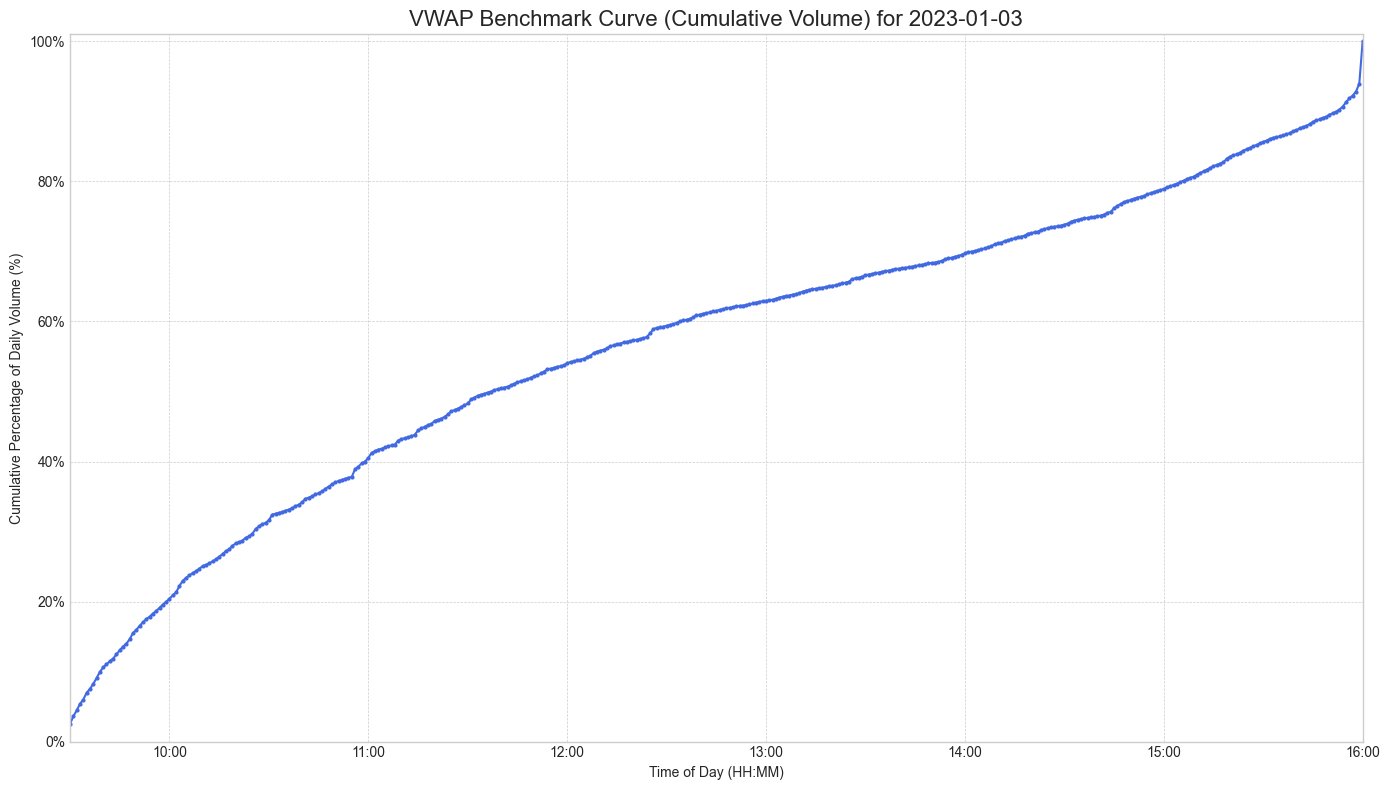

In [82]:
target_date_str = '2023-01-03'
target_date_obj = datetime.datetime.strptime(target_date_str, '%Y-%m-%d').date()
specific_day_curve = all_curves.get(target_date_obj)
plot_daily_volume_curve(specific_day_curve, target_date_str)